In [1]:
# ThoroughBet Simulation


## Load necessary modules

In [2]:
import numpy as np

from utils import settings, timestamp, YEAR
from utils.arrayview import ArrayView, TimeseriesView


from prediction.models.preprocessing import Model
from prediction.models.prediction import factornames_trimmed
from prediction.models.parameters import factor_build_end
from prediction.tools.clustering import write_dic_to_simdata, dic_to_tenzor, ll_diff

## Load data

In [3]:
av = ArrayView.from_file(settings.paths.join('brain_final2cut.av.bcolz'))

In [4]:
tsav = {}
sl = 0
while True:
    try:
        tsav[sl] = ArrayView.from_file(settings.paths.join('brain_final2_slice_%s.av.bcolz' % sl))
    except ValueError:
        break
    sl += 1

In [5]:
mod = Model(av, oos_start=factor_build_end+YEAR)

In [6]:
high_kurtosis_factors =  ['z64f5be67e', 'z90adc182a', 'z7081bf371', 'z34b808e99', 'z757be272e', 'z5a85cd6a9',
                         'zf991b634a', 'z62651f605', 'zd002b7067', 'z2ef7fedca', 'z6f11029f7', 'z412893062',
                          'z919b9585a', 'z89b0eda37', 'z31780b3f4', 'z6631693d3', 'z0b27f29ad', 'zd7cd94e4c', 
                          'zf5b2aef2a']
price_factors = ['zb392bb74a', 'z6809c316d', 'zd678f0538', 'z027f9f0f5', 'z88e79930c', 'z4a72dc02f',
                 'z1a3573928', 'z7b15df227']

In [7]:
%time factors = mod._preprocess_factors(factornames_trimmed, high_kurtosis_factors = high_kurtosis_factors,\
                                        price_factors = price_factors, verbose=True)

INFO:models:Getting factors from av and rescaling...


. . . . .

INFO:models:Filling in missing values...
INFO:models:Computing each factor as linear combination of all the others...


 . . . . .

INFO:models:Number of missing patterns: 7754


 . . . . . . .

INFO:models:Transforming factors by applying CL-model on their Taylor expansions...


 . . .

prediction/models/clmodel.py:116: RuntimeWarning: invalid value encountered in sqrt
  coefse = np.sqrt(np.diag(information_matrix))


 . .CPU times: user 3min 5s, sys: 2.15 s, total: 3min 7s
Wall time: 54.1 s



In [8]:
predict_mask = mod.is1|mod.is2|mod.oos

In [9]:
def old_data(num, is1=mod.is1):
    
    first_is1 = np.where(is1 ==True)[0][0]
    past_events = np.unique(av.event_id[av.event_id < av.event_id[first_is1]])[-int(num):]
    
    return np.in1d(av.event_id, past_events)

In [10]:
mask_past = old_data(4000)

In [11]:
np.where(predict_mask ==True)[0][0], np.where(mask_past ==True)[0][0]

(1123738, 1085943)

In [12]:
def new_factors_array (X, predict_mask =predict_mask):
    
    
    factors_new = np.zeros((X.shape[1], predict_mask.shape[0]))
    factors_new[:, predict_mask] = X.T
    
    return factors_new

In [13]:
def DF(mask, factors, av, factors_names, other_names):
    
    import pandas as pd
    
    df = pd.DataFrame(data =factors[:, mask].T , columns = factors_names)
    for col in other_names :
        
        df[col] = av[col][mask]
        
    return df

In [14]:
import pandas as pd
pd.set_option('display.max_columns', 90)

col_names = ['f{}'.format(i) for i in range(1,58)]

df = DF (predict_mask, factors, av, col_names, ['event_id', 'runner_id', 'result', 'start_time', 'jockey', 'trainer',
                                               'speed', 'norm_speed','prize'])
df['is1'] = mod.is1 [predict_mask]
df['oos'] = mod.oos [predict_mask]
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos
0,0.066411,1.812371,0.140033,0.007517,-0.000144,0.370123,0.886900,-0.000888,1.492165,-0.504111,0.174814,0.783295,0.478420,0.026520,1.220996,0.317993,-0.000908,-0.000375,0.004848,-0.017851,0.043987,-0.237318,1.049784,-0.046792,-0.006285,0.000628,-0.065017,0.001235,-0.018441,0.274973,-0.487135,0.084544,-0.116107,0.002079,-0.001362,-0.160866,0.091133,0.966224,2.384186e-07,2.492460,0.753668,-0.000403,0.234473,0.250251,0.023256,0.628183,0.098600,-0.014886,-0.089427,0.536910,-0.012463,-0.143313,0.943943,0.417261,-0.000921,-0.000780,0.119300,293661,360456,3,1.443704e+09,5870,5165,15.735644,-0.227720,3235.0,True,False
1,-0.154959,0.615217,-0.069783,-0.001667,0.001293,0.163312,-0.100933,-0.016348,0.145181,0.085654,0.057041,0.430980,0.132121,0.013572,0.413222,0.189882,-0.016198,-0.002962,0.014569,-0.015469,-0.026517,0.277365,-0.374422,0.029834,0.056561,-0.000221,0.116112,-0.002068,-0.024272,0.090061,-0.030274,-0.498561,0.035182,-0.018710,0.029094,0.031624,-0.061174,0.254454,2.384186e-07,1.648349,0.073634,-0.650115,0.177804,-0.052191,-0.034483,0.370725,-0.247407,-0.023127,0.550295,-0.121513,0.112166,0.040612,0.224962,0.057615,-0.016085,-0.017330,0.026977,293661,375590,5,1.443704e+09,10816,448,15.622030,-0.341334,3235.0,True,False
2,0.066411,0.442863,0.069257,0.007517,-0.000144,0.207937,-0.100933,0.014814,-0.010327,-0.566212,0.355908,0.246179,-0.305634,0.031401,0.364949,0.144203,0.014812,0.017871,0.009206,0.012740,-0.014440,0.264392,0.339009,0.039109,-0.006285,0.000204,0.173482,0.001554,0.055569,-0.092425,-0.266650,0.043125,0.001112,0.002079,-0.011063,0.171808,0.014969,0.155725,2.384186e-07,0.941642,0.146075,-0.109316,0.106961,0.005249,0.083641,0.144267,0.098600,0.081410,-0.152771,-0.183572,-0.012463,0.159303,0.488670,0.036059,0.014800,0.014925,0.051179,293661,374610,7,1.443704e+09,10817,10804,15.565223,-0.398141,3235.0,True,False
3,-0.154959,0.765992,0.129201,-0.025480,-0.000144,0.112316,-0.257098,0.012801,0.304235,0.226926,-0.260937,-0.048408,-0.043558,0.019547,0.549890,-0.284258,0.012796,0.003470,0.009206,0.011642,-0.004117,-0.122674,-0.421721,0.048495,-0.006285,-0.000031,0.239139,0.001421,-0.018441,-0.134330,0.250868,0.486319,0.086636,0.002079,-0.009765,0.190400,0.130183,0.447011,2.384186e-07,0.498932,-0.041847,0.597555,0.001817,-0.037324,-0.019826,-0.163311,-0.247407,-0.014886,0.461782,0.289931,-0.012463,0.088135,-0.126984,-0.495465,0.012784,0.012911,-0.262583,293661,373638,1,1.443704e+09,63,64,15.849259,-0.114104,3235.0,True,False
4,0.066411,0.329832,-0.093768,0.007517,-0.000144,0.112316,0.503109,-0.024129,1.263628,-0.359817,0.086009,-0.048408,-0.043558,0.031450,1.252166,0.158341,-0.024174,-0.019263,0.009206,0.012740,-0.038280,0.105890,0.209527,-0.033071,-0.006285,-0.000099,-0.037533,0.000975,0.097792,0.022945,-0.043148,-0.245328,-0.009627,0.002079,0.011331,-0.122763,-0.217356,1.080508,2.384186e-07,-0.004469,0.049962,0.495737,0.116301,-0.110655,-0.044347,-0.163311,0.098600,0.023900,-0.237007,-0.440662,-0.012463,-0.125458,0.136239,0.442488,-0.024187,-0.024024,0.267151,293661,347906,4,1.443704e+09,10921,299,15.712922,-0.250442,3235.0,True,False


In [15]:
np.log(df['prize']).max(), np.log(df['prize']).min()

(13.683315, 0.0)

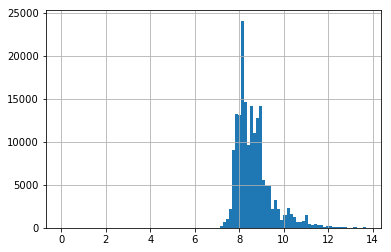

In [16]:
%matplotlib inline
np.log(df.prize).hist(bins = 100)

In [18]:
max_log_prize = np.log(df['prize']).max()
df['prize_log'] = (np.log(df['prize']) + 1e-6)/max_log_prize

In [19]:
print 'number of jockeys that have one a win  ' ,np.sum(df['jockey'].value_counts() ==1)
print 'whole number of jockeys  ',  len(df['jockey'].unique())

number of jockeys that have one a win   220
whole number of jockeys   1482


In [20]:
#rating = lambda x: 1.25 -0.25* x if (x >0 )& (x  <4) else 0
rating = lambda x: 1./x if (x >0 )& (x <=4) else 0

def compute_nfp_weight (results, cutoff =None):
    
    finpos_raw = results.astype(float)
    finpos_raw[finpos_raw == -1] == 100
    finpos_raw[(finpos_raw == -0) | (finpos_raw <= -2)] == np.nan
    nfp_weight = 1/(np.log(finpos_raw)/np.log(2) + 1)
    if cutoff is not None:
        with np.errstate(invalid ='ignore'):
            nfp_weight[finpos_row > cutoff] == 0.0
            
    return nfp_weight

In [21]:
df['rating'] = df['result'].apply(rating) * df['prize_log']
#df['rating'] = compute_nfp_weight(df['result']) * df['prize_log']
#df['event'] =1

### 1.Speed rating

In [22]:
df['event_speed'] = df.groupby('event_id')['speed'].transform(lambda x: x/x.max())

In [25]:
df = df.join(df.groupby('event_id')['event_speed'].min(), on ='event_id', rsuffix ='_min')
df.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,event_speed_min
181984,-0.001791,0.305292,0.002202,-0.043580,0.000176,-0.830468,0.546406,0.189813,0.088740,-0.054661,-0.355233,0.636184,-0.373760,0.019384,0.005445,-0.167969,0.189934,0.170681,0.201674,0.013882,0.043565,-0.262285,-0.314926,-0.054621,-0.199356,-0.001768,-0.203631,-0.001118,0.057663,0.247347,0.075659,-0.194570,0.036453,-0.047364,0.129998,-0.142565,-0.004153,0.011022,1.192093e-07,0.259280,0.049065,0.049889,0.070893,-0.095818,0.031717,0.258435,0.098857,0.009017,-0.094818,-0.271917,-0.10662,-0.044507,0.044462,-0.001848,0.189937,0.189809,-0.273905,348044,309510,4,1.491325e+09,10830,12095,14.738428,-0.485264,2911.0,False,True,0.582918,0.145730,0.984206,0.971534
181985,-0.001791,0.158784,-0.094404,0.034454,-0.001054,0.383030,-0.021071,-0.450935,0.240886,0.245064,-0.009981,-0.430830,0.091180,0.050764,0.107631,-0.061776,-0.451033,-0.482679,-0.376243,-0.022931,-0.054987,0.080867,0.966551,0.034155,0.082771,-0.002208,0.042784,0.001130,0.106020,-0.145781,0.055507,0.015852,-0.063126,-0.687815,-0.097964,-0.105352,-0.143244,-0.014678,1.192093e-07,0.259280,0.033785,-0.019956,0.106958,0.283570,-0.031777,-0.310286,0.098857,0.009175,0.155430,0.150893,-0.10662,0.092016,0.134832,0.022426,-0.451031,-0.450936,-0.081369,348044,134162,3,1.491325e+09,19689,755,14.820935,-0.402757,2911.0,False,True,0.582918,0.194306,0.989715,0.971534
181986,0.121731,-0.607752,0.112927,0.040380,0.000176,-0.811391,-0.353688,0.098327,-0.171542,-0.088160,-0.115260,0.156570,-0.142259,-0.269422,-0.365013,-0.124193,0.098370,0.038713,0.105367,0.082842,0.019753,0.203087,-0.604638,0.002315,-0.032396,-0.002944,0.289072,0.000932,-0.371020,0.060209,0.340068,-0.053617,0.105134,0.149609,0.030614,0.363646,0.091233,-0.329113,1.192093e-07,-0.365193,0.039436,-0.019956,-0.108792,-0.135291,0.037264,-0.310286,0.098857,-0.033725,-0.085344,-0.211192,-0.10662,0.004154,-0.135623,-0.107339,0.098368,0.098361,-0.049301,348044,167167,7,1.491325e+09,7281,20559,14.548663,-0.675029,2911.0,False,True,0.582918,0.000000,0.971534,0.971534
181987,-0.459110,-1.184132,0.069584,-0.114837,0.000176,0.713696,0.333819,-0.202482,-0.113766,-0.386204,0.396670,-0.607411,0.014962,0.044718,-0.437826,0.086846,-0.202673,-0.087505,-0.238376,-0.022931,0.008674,-0.305982,0.671716,-0.023509,0.040691,-0.001821,-0.163256,0.000260,-0.170459,0.136150,-0.560360,-0.151810,-0.202459,0.301643,-0.248122,-0.158359,0.072683,-0.127920,1.192093e-07,-0.675358,-0.778373,-0.019956,0.007761,0.053726,0.006090,-0.310286,0.098857,-0.266593,-0.093705,0.063148,-0.10662,-0.135520,-0.675076,-0.022018,-0.202678,-0.202493,-0.008656,348044,138643,5,1.491325e+09,8704,23303,14.709551,-0.514141,2911.0,False,True,0.582918,0.000000,0.982277,0.971534
181988,0.121731,-0.850804,-0.073879,0.040380,0.000176,-0.918695,0.223040,0.147873,-0.347024,0.089216,-0.177962,-0.669320,-0.015987,0.053083,-0.279684,-0.133650,0.147968,0.121095,0.195003,-0.014636,-0.011203,-0.142182,-1.057921,0.086318,0.014580,0.013167,-0.254831,0.001233,0.106020,-0.203730,0.351890,-0.199153,0.124085,0.060165,0.121153,-0.111032,-0.039353,-0.156794,1.192093e-07,-0.798513,0.093016,0.049889,-0.191833,-0.003674,-0.024356,-0.310286,-0.247143,0.106391,-0.093148,-0.328325,-0.10662,0.083268,-0.282246,-0.001047,0.147968,0.147897,0.082279,348044,311581,6,1.491325e+09,19225,20927,14.680673,-0.543020,2911.0,False,True,0.582918,0.000000,0.980349,0.971534


In [26]:
df['event_speed'][df['event_speed'].isnull()] = df['event_speed_min'][df['event_speed'].isnull()]

/home/oleg/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


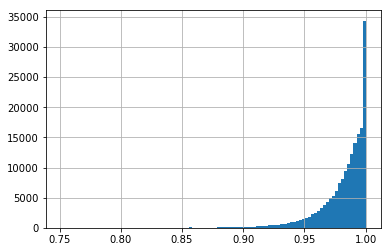

In [27]:
df['event_speed'].hist(bins =100)

In [36]:
(1 - df['event_speed'][df['result'] ==2]).describe()

count    17586.000000
mean         0.002832
std          0.003365
min          0.000026
25%          0.000758
50%          0.001754
75%          0.003759
max          0.062121
Name: event_speed, dtype: float64

In [40]:
0.5 / (1 - df['event_speed'][df['result'] ==2]).mean()# - df['event_speed'][df['result'] ==2]).describe()

176.52981806562784

In [58]:
df['cum_speed_rating'] = df.groupby('runner_id')['event_speed'].cumsum()/(1 + df.groupby('runner_id').cumcount())
df['cum_speed_rating'] = df.groupby('runner_id')['cum_speed_rating'].shift().fillna(0)
df['dif_speed_rating'] = df.groupby('runner_id')['cum_speed_rating'].diff().fillna(0)
df.tail(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,min_speed,cum_speed_rating,dif_speed_rating
181979,-0.056881,-0.317687,0.202016,0.015841,0.002667,0.511885,0.442847,0.059621,-0.240924,-0.226607,-0.023539,0.378445,-0.027856,0.050171,-0.469921,0.345880,0.059679,0.068590,0.126539,0.016491,-0.008717,-0.124131,0.555764,-0.051147,0.027844,-0.000325,-0.003991,-0.000096,0.038039,-0.094261,-0.018004,0.062109,-0.021704,-0.000057,0.072905,0.323421,0.191362,-0.499624,0.000000e+00,0.021170,-0.203521,0.012707,-0.040997,0.050638,-0.000287,0.103665,0.139693,-0.055551,-0.092549,0.227700,-0.149707,-0.077288,0.057792,0.153961,0.059680,0.059630,-0.036826,348043,367414,4,1.491323e+09,3988,7594,14.645664,-0.578028,2911.0,False,True,0.582918,0.000000,0.983935,NaN,0.987442,0.000488
181980,-0.488569,-0.243749,-0.076182,-0.063364,0.002667,-0.451243,-0.651035,0.073151,-0.049601,-0.029875,0.016107,0.270742,-0.128086,0.049829,0.072729,-0.189815,0.073224,0.076522,0.122204,-0.002141,0.003946,-0.196012,-0.821568,0.017528,-0.243819,0.000114,-0.335200,-0.001673,-0.153911,-0.050911,-0.138538,-0.002159,-0.084605,-0.061755,0.069192,-0.229496,-0.008089,0.285792,0.000000e+00,-0.323502,-0.776113,0.012707,0.058548,0.287032,0.013811,0.103665,-0.209539,-0.233003,-0.007231,-0.231449,-0.149707,0.039418,-0.043990,-0.160492,0.073226,0.073159,0.039206,348043,340100,5,1.491323e+09,10134,792,14.516791,-0.706901,2911.0,False,True,0.582918,0.000000,0.975277,NaN,0.995136,0.000259
181981,0.268445,-0.317687,0.112516,0.015841,0.002667,-0.639942,0.090197,-0.001119,0.031336,-0.634762,-0.124667,-0.781738,-0.100919,-0.153563,-0.981923,-0.219825,-0.001130,0.019463,-0.052810,-0.006888,0.009549,-0.376492,-0.488405,-0.022975,-0.054316,-0.000161,-0.393080,0.000249,0.087987,0.177421,-0.278714,0.103931,-0.331853,-0.000057,0.022925,-0.305652,0.158527,-0.892804,0.000000e+00,-0.576013,0.433982,0.082485,-0.113873,-0.062305,0.000921,-0.457939,0.139693,0.126029,-0.047144,-0.082212,-0.149707,0.036155,-0.871579,0.029940,-0.001130,-0.001114,-0.099665,348043,346448,1,1.491323e+09,6516,404,14.884795,-0.338897,2911.0,False,True,0.582918,0.582918,1.000000,NaN,0.986619,-0.001511
181982,-0.001791,1.254302,-0.022497,0.008750,0.000176,0.879747,-0.571919,0.226919,0.080797,-0.170395,0.188068,0.801818,0.552407,0.056888,0.592190,0.249970,0.227026,0.193635,0.109091,-0.014636,0.034843,0.155043,0.256262,-0.075551,0.033795,-0.002538,0.228382,0.001289,0.135889,-0.123149,-0.201426,0.633695,-0.009031,-0.047364,0.096538,0.072995,0.021943,0.398283,1.192093e-07,0.757530,0.132928,-0.019956,0.026145,-0.006845,-0.033494,0.724272,-0.247143,0.072489,0.267864,0.694115,0.639717,0.089280,0.341661,-0.007309,0.227034,0.226856,0.057114,348044,365184,1,1.491325e+09,10807,64,14.974947,-0.248745,2911.0,False,True,0.582918,0.582918,1.000000,NaN,0.996272,0.000932
181983,0.221020,0.924309,0.006067,0.034454,0.000176,0.584080,-0.156588,-0.009517,0.221907,0.365142,0.073698,0.112989,-0.126542,0.044584,0.377257,0.150771,-0.009592,0.046059,0.003483,-0.021590,-0.040644,0.271452,0.082956,0.030894,0.059916,-0.001888,0.061481,-0.003726,0.135889,0.028955,-0.061339,-0.050397,0.008943,0.271127,-0.032218,0.080667,0.000890,0.219199,1.192093e-07,0.562974,0.430144,-0.019956,0.088870,-0.095666,0.014556,0.258435,0.098857,0.103245,-0.056278,-0.096723,-0.106620,-0.088691,0.571991,0.117136,-0.009597,-0.009494,0.273837,348044,157115,2,1.491325e+09,8818,185,14.969447,-0.254245,2911.0,False,True,0.582918,0.291459,0.999633,NaN,0.982789,0.000902
181984,-0.001791,0.305292,0.002202,-0.043580,0.000176,-0.830468,0.546406,0.189813,0.088740,-0.054661,-0.355233,0.636184,-0.373760,0.019384,0.005445,-0.167969,0.189934,0.170681,0.201674,0.013882,0.043565,-0.262285,-0.314926,-0.054621,-0.199356,-0.0

In [61]:
df['cum_speed_rating'].max(), df['cum_speed_rating'].min()

(1.0, 0.0)

In [66]:
new_factors1 =  np.vstack((factors, 
    new_factors_array (df[['cum_speed_rating', 'dif_speed_rating']])))
new_factors.shape

(59, 1631851)

#### fit our model speed rating

In [67]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors1, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

prediction/models/preprocessing.py:320: RuntimeWarning: divide by zero encountered in log
  step2factors = np.concatenate((fb, fl, np.log(probs).reshape((1, -1))), axis=0)


. . . . . . . . . . 10
CPU times: user 2min 55s, sys: 58.3 s, total: 3min 54s
Wall time: 1min 52s
new_model_likelihood
[[-1809.67932823 -1998.17962538 -1998.17962538]
 [-1815.38477528 -1994.57672732 -1994.57672732]
 [-1820.55303152 -1992.53300701 -1992.53300701]
 [-1825.13066617 -1980.44861508 -1980.44861508]
 [-1845.46506721 -1958.84756422 -1958.84756422]
 [-1863.18705802 -1953.00453049 -1953.00453049]
 [-1903.88098981 -1925.48682761 -1925.48682761]
 [-1921.30552153 -1903.46787954 -1903.46787954]
 [-1924.08951098 -1903.26190831 -1903.26190831]
 [-1929.11656259 -1895.97994911 -1895.97994911]
 [    0.             0.             0.        ]]
..................


### 2.Traiter rating

In [68]:
df['cum_trainers_raiting'] = df.groupby('trainer')['rating'].cumsum()/(1 + df.groupby('trainer').cumcount())

In [69]:
df['cum_trainers_raiting'] = df.groupby('trainer')['cum_trainers_raiting'].shift().fillna(0)
df['trainers_raiting'] = df.groupby('trainer')['rating'].shift().fillna(0)

In [70]:
df['dif_tr_raiting'] = df.groupby('trainer')['cum_trainers_raiting'].diff().fillna(0)
df['dif2_tr_raiting'] = df.groupby('trainer')['dif_tr_raiting'].diff().fillna(0)
df.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,min_speed,cum_speed_rating,dif_speed_rating,cum_trainers_raiting,trainers_raiting,dif_tr_raiting,dif2_tr_raiting
181984,-0.001791,0.305292,0.002202,-0.043580,0.000176,-0.830468,0.546406,0.189813,0.088740,-0.054661,-0.355233,0.636184,-0.373760,0.019384,0.005445,-0.167969,0.189934,0.170681,0.201674,0.013882,0.043565,-0.262285,-0.314926,-0.054621,-0.199356,-0.001768,-0.203631,-0.001118,0.057663,0.247347,0.075659,-0.194570,0.036453,-0.047364,0.129998,-0.142565,-0.004153,0.011022,1.192093e-07,0.259280,0.049065,0.049889,0.070893,-0.095818,0.031717,0.258435,0.098857,0.009017,-0.094818,-0.271917,-0.10662,-0.044507,0.044462,-0.001848,0.189937,0.189809,-0.273905,348044,309510,4,1.491325e+09,10830,12095,14.738428,-0.485264,2911.0,False,True,0.582918,0.000000,0.984206,NaN,0.971411,0.001645,0.041441,0.000000,-0.000568,0.000016
181985,-0.001791,0.158784,-0.094404,0.034454,-0.001054,0.383030,-0.021071,-0.450935,0.240886,0.245064,-0.009981,-0.430830,0.091180,0.050764,0.107631,-0.061776,-0.451033,-0.482679,-0.376243,-0.022931,-0.054987,0.080867,0.966551,0.034155,0.082771,-0.002208,0.042784,0.001130,0.106020,-0.145781,0.055507,0.015852,-0.063126,-0.687815,-0.097964,-0.105352,-0.143244,-0.014678,1.192093e-07,0.259280,0.033785,-0.019956,0.106958,0.283570,-0.031777,-0.310286,0.098857,0.009175,0.155430,0.150893,-0.10662,0.092016,0.134832,0.022426,-0.451031,-0.450936,-0.081369,348044,134162,3,1.491325e+09,19689,755,14.820935,-0.402757,2911.0,False,True,0.582918,0.194306,0.989715,NaN,0.987887,-0.000270,0.101129,0.291459,0.000140,-0.000024
181986,0.121731,-0.607752,0.112927,0.040380,0.000176,-0.811391,-0.353688,0.098327,-0.171542,-0.088160,-0.115260,0.156570,-0.142259,-0.269422,-0.365013,-0.124193,0.098370,0.038713,0.105367,0.082842,0.019753,0.203087,-0.604638,0.002315,-0.032396,-0.002944,0.289072,0.000932,-0.371020,0.060209,0.340068,-0.053617,0.105134,0.149609,0.030614,0.363646,0.091233,-0.329113,1.192093e-07,-0.365193,0.039436,-0.019956,-0.108792,-0.135291,0.037264,-0.310286,0.098857,-0.033725,-0.085344,-0.211192,-0.10662,0.004154,-0.135623,-0.107339,0.098368,0.098361,-0.049301,348044,167167,7,1.491325e+09,7281,20559,14.548663,-0.675029,2911.0,False,True,0.582918,0.000000,0.971534,NaN,0.987000,0.000404,0.073807,0.000000,-0.000258,0.000002
181987,-0.459110,-1.184132,0.069584,-0.114837,0.000176,0.713696,0.333819,-0.202482,-0.113766,-0.386204,0.396670,-0.607411,0.014962,0.044718,-0.437826,0.086846,-0.202673,-0.087505,-0.238376,-0.022931,0.008674,-0.305982,0.671716,-0.023509,0.040691,-0.001821,-0.163256,0.000260,-0.170459,0.136150,-0.560360,-0.151810,-0.202459,0.301643,-0.248122,-0.158359,0.072683,-0.127920,1.192093e-07,-0.675358,-0.778373,-0.019956,0.007761,0.053726,0.006090,-0.310286,0.098857,-0.266593,-0.093705,0.063148,-0.10662,-0.135520,-0.675076,-0.022018,-0.202678,-0.202493,-0.008656,348044,138643,5,1.491325e+09,8704,23303,14.709551,-0.514141,2911.0,False,True,0.582918,0.000000,0.982277,NaN,0.975660,0.000311,0.109030,0.564548,0.003703,0.002025
181988,0.121731,-0.850804,-0.073879,0.040380,0.000176,-0.918695,0.223040,0.147873,-0.347024,0.089216,-0.177962,-0.669320,-0.015987,0.053083,-0.279684,-0.133650,0.147968,0.121095,0.195003,-0.014636,-0.011203,-0.142182,-1.057921,0.086318,0.014580,0.013167,-0.254831,0.001233,0.106020,-0.203730,0.351890,-0.199153,0.124085,0.060165,0.121153,-0.111032,-0.039353,-0.156794,1.192093e-07,-0.798513,0.093016,0.049889,-0.191833,-0.003674,-0.024356,-0.310286,-0.247143,0.106391,-0.093148,-0.328325,-0.10662,0.083268,-0.282246,-0.001047,0.147968,0.147897,0.082279,348044,311581,6,1.491325e+09,19225,20927,14.680673,-0.543020,2911.0,False,True,0.582918,0.000000,0.980349,NaN,0.961506,0.004503,0.071573,

In [72]:
df[['cum_trainers_raiting', 'dif_tr_raiting', 'dif2_tr_raiting']].min()

cum_trainers_raiting    0.000000
dif_tr_raiting         -0.659314
dif2_tr_raiting        -1.318628
dtype: float64

In [73]:
new_factors2 =  np.vstack((factors, 
    new_factors_array (df[['cum_trainers_raiting', 'dif_tr_raiting', 'dif2_tr_raiting']])))
new_factors.shape

(60, 1631851)

#### fit our model  trainer rating

In [74]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors2, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 3min 2s, sys: 57.1 s, total: 3min 59s
Wall time: 1min 58s
new_model_likelihood
[[-1809.57818713 -1997.09241688 -1997.09241688]
 [-1815.28235923 -1993.37021412 -1993.37021412]
 [-1820.46000475 -1991.14924931 -1991.14924931]
 [-1825.04870386 -1978.83927798 -1978.83927798]
 [-1845.3648941  -1957.10087441 -1957.10087441]
 [-1863.08901734 -1951.34311503 -1951.34311503]
 [-1903.74399023 -1924.13488808 -1924.13488808]
 [-1921.0922597  -1902.58269053 -1902.58269053]
 [-1923.85920233 -1902.44438702 -1902.44438702]
 [-1928.85099994 -1895.38236017 -1895.38236017]
 [    0.             0.             0.        ]]
..................


### 3. Jockey rating

In [75]:
df['cum_jockeys_raiting'] = df.groupby('jockey')['rating'].cumsum()/(1 + df.groupby('jockey').cumcount())
df['cum_jockeys_raiting'] = df.groupby('jockey')['cum_jockeys_raiting'].shift().fillna(0)
df['jockeys_raiting'] = df.groupby('jockey')['rating'].shift().fillna(0)

In [76]:
df['dif_joc_raiting'] = df.groupby('jockey')['cum_jockeys_raiting'].diff().fillna(0)
df['dif2_joc_raiting'] = df.groupby('jockey')['dif_joc_raiting'].diff().fillna(0)
df.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,min_speed,cum_speed_rating,dif_speed_rating,cum_trainers_raiting,trainers_raiting,dif_tr_raiting,dif2_tr_raiting,cum_jockeys_raiting,jockeys_raiting,dif_joc_raiting,dif2_joc_raiting
181984,-0.001791,0.305292,0.002202,-0.043580,0.000176,-0.830468,0.546406,0.189813,0.088740,-0.054661,-0.355233,0.636184,-0.373760,0.019384,0.005445,-0.167969,0.189934,0.170681,0.201674,0.013882,0.043565,-0.262285,-0.314926,-0.054621,-0.199356,-0.001768,-0.203631,-0.001118,0.057663,0.247347,0.075659,-0.194570,0.036453,-0.047364,0.129998,-0.142565,-0.004153,0.011022,1.192093e-07,0.259280,0.049065,0.049889,0.070893,-0.095818,0.031717,0.258435,0.098857,0.009017,-0.094818,-0.271917,-0.10662,-0.044507,0.044462,-0.001848,0.189937,0.189809,-0.273905,348044,309510,4,1.491325e+09,10830,12095,14.738428,-0.485264,2911.0,False,True,0.582918,0.000000,0.984206,NaN,0.971411,0.001645,0.041441,0.000000,-0.000568,0.000016,0.099672,0.000000,-0.000136,-0.000856
181985,-0.001791,0.158784,-0.094404,0.034454,-0.001054,0.383030,-0.021071,-0.450935,0.240886,0.245064,-0.009981,-0.430830,0.091180,0.050764,0.107631,-0.061776,-0.451033,-0.482679,-0.376243,-0.022931,-0.054987,0.080867,0.966551,0.034155,0.082771,-0.002208,0.042784,0.001130,0.106020,-0.145781,0.055507,0.015852,-0.063126,-0.687815,-0.097964,-0.105352,-0.143244,-0.014678,1.192093e-07,0.259280,0.033785,-0.019956,0.106958,0.283570,-0.031777,-0.310286,0.098857,0.009175,0.155430,0.150893,-0.10662,0.092016,0.134832,0.022426,-0.451031,-0.450936,-0.081369,348044,134162,3,1.491325e+09,19689,755,14.820935,-0.402757,2911.0,False,True,0.582918,0.194306,0.989715,NaN,0.987887,-0.000270,0.101129,0.291459,0.000140,-0.000024,0.094218,0.324341,0.000627,0.000883
181986,0.121731,-0.607752,0.112927,0.040380,0.000176,-0.811391,-0.353688,0.098327,-0.171542,-0.088160,-0.115260,0.156570,-0.142259,-0.269422,-0.365013,-0.124193,0.098370,0.038713,0.105367,0.082842,0.019753,0.203087,-0.604638,0.002315,-0.032396,-0.002944,0.289072,0.000932,-0.371020,0.060209,0.340068,-0.053617,0.105134,0.149609,0.030614,0.363646,0.091233,-0.329113,1.192093e-07,-0.365193,0.039436,-0.019956,-0.108792,-0.135291,0.037264,-0.310286,0.098857,-0.033725,-0.085344,-0.211192,-0.10662,0.004154,-0.135623,-0.107339,0.098368,0.098361,-0.049301,348044,167167,7,1.491325e+09,7281,20559,14.548663,-0.675029,2911.0,False,True,0.582918,0.000000,0.971534,NaN,0.987000,0.000404,0.073807,0.000000,-0.000258,0.000002,0.144749,0.000000,-0.000174,-0.000249
181987,-0.459110,-1.184132,0.069584,-0.114837,0.000176,0.713696,0.333819,-0.202482,-0.113766,-0.386204,0.396670,-0.607411,0.014962,0.044718,-0.437826,0.086846,-0.202673,-0.087505,-0.238376,-0.022931,0.008674,-0.305982,0.671716,-0.023509,0.040691,-0.001821,-0.163256,0.000260,-0.170459,0.136150,-0.560360,-0.151810,-0.202459,0.301643,-0.248122,-0.158359,0.072683,-0.127920,1.192093e-07,-0.675358,-0.778373,-0.019956,0.007761,0.053726,0.006090,-0.310286,0.098857,-0.266593,-0.093705,0.063148,-0.10662,-0.135520,-0.675076,-0.022018,-0.202678,-0.202493,-0.008656,348044,138643,5,1.491325e+09,8704,23303,14.709551,-0.514141,2911.0,False,True,0.582918,0.000000,0.982277,NaN,0.975660,0.000311,0.109030,0.564548,0.003703,0.002025,0.110171,0.648682,0.000638,0.000768
181988,0.121731,-0.850804,-0.073879,0.040380,0.000176,-0.918695,0.223040,0.147873,-0.347024,0.089216,-0.177962,-0.669320,-0.015987,0.053083,-0.279684,-0.133650,0.147968,0.121095,0.195003,-0.014636,-0.011203,-0.142182,-1.057921,0.086318,0.014580,0.013167,-0.254831,0.001233,0.106020,-0.203730,0.351890,-0.199153,0.124085,0.060165,0.121153,-0.111032,-0.039353,-0.156794,1.192093e-07,-0.798513,0.093016,0.049889,-0.191833,-0.003674,-0.024356,-0.310286,-0.247143,0.106391,-0.09

In [78]:
df[['cum_jockeys_raiting', 'dif_joc_raiting', 'dif2_joc_raiting']].max()

cum_jockeys_raiting    0.876150
dif_joc_raiting        0.876150
dif2_joc_raiting       1.054746
dtype: float64

In [79]:
new_factors3 =  np.vstack((factors, 
    new_factors_array (df[['cum_jockeys_raiting', 'dif_joc_raiting', 'dif2_joc_raiting']])))
new_factors.shape

(60, 1631851)

#### fit our model  jockey rating

In [80]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors3, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 3min 3s, sys: 57.5 s, total: 4min
Wall time: 1min 59s
new_model_likelihood
[[-1809.53890605 -1997.15492173 -1997.15492173]
 [-1815.24881929 -1993.37341739 -1993.37341739]
 [-1820.42460494 -1991.11078816 -1991.11078816]
 [-1825.01620336 -1978.77797055 -1978.77797055]
 [-1845.33705807 -1956.9841759  -1956.9841759 ]
 [-1863.06658887 -1951.25381309 -1951.25381309]
 [-1903.73349246 -1924.11751507 -1924.11751507]
 [-1921.09989589 -1902.61658357 -1902.61658357]
 [-1923.8733919  -1902.45265491 -1902.45265491]
 [-1928.85113622 -1895.34853617 -1895.34853617]
 [    0.             0.             0.        ]]
..................


### 4. Horse rating

In [81]:
df['cum_horse_raiting'] = df.groupby('runner_id')['rating'].cumsum()/(1 + df.groupby('runner_id').cumcount())
df['cum_horse_raiting'] = df.groupby('runner_id')['cum_horse_raiting'].shift().fillna(0)
df['dif_horse_raiting'] = df.groupby('runner_id')['cum_horse_raiting'].diff().fillna(0)
df['dif2_horse_raiting'] = df.groupby('runner_id')['dif_horse_raiting'].diff().fillna(0)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,event_id,runner_id,result,start_time,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,min_speed,cum_speed_rating,dif_speed_rating,cum_trainers_raiting,trainers_raiting,dif_tr_raiting,dif2_tr_raiting,cum_jockeys_raiting,jockeys_raiting,dif_joc_raiting,dif2_joc_raiting,cum_horse_raiting,dif_horse_raiting,dif2_horse_raiting
0,0.066411,1.812371,0.140033,0.007517,-0.000144,0.370123,0.886900,-0.000888,1.492165,-0.504111,0.174814,0.783295,0.478420,0.026520,1.220996,0.317993,-0.000908,-0.000375,0.004848,-0.017851,0.043987,-0.237318,1.049784,-0.046792,-0.006285,0.000628,-0.065017,0.001235,-0.018441,0.274973,-0.487135,0.084544,-0.116107,0.002079,-0.001362,-0.160866,0.091133,0.966224,2.384186e-07,2.492460,0.753668,-0.000403,0.234473,0.250251,0.023256,0.628183,0.098600,-0.014886,-0.089427,0.536910,-0.012463,-0.143313,0.943943,0.417261,-0.000921,-0.000780,0.119300,293661,360456,3,1.443704e+09,5870,5165,15.735644,-0.227720,3235.0,True,False,0.590631,0.196877,0.992832,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.154959,0.615217,-0.069783,-0.001667,0.001293,0.163312,-0.100933,-0.016348,0.145181,0.085654,0.057041,0.430980,0.132121,0.013572,0.413222,0.189882,-0.016198,-0.002962,0.014569,-0.015469,-0.026517,0.277365,-0.374422,0.029834,0.056561,-0.000221,0.116112,-0.002068,-0.024272,0.090061,-0.030274,-0.498561,0.035182,-0.018710,0.029094,0.031624,-0.061174,0.254454,2.384186e-07,1.648349,0.073634,-0.650115,0.177804,-0.052191,-0.034483,0.370725,-0.247407,-0.023127,0.550295,-0.121513,0.112166,0.040612,0.224962,0.057615,-0.016085,-0.017330,0.026977,293661,375590,5,1.443704e+09,10816,448,15.622030,-0.341334,3235.0,True,False,0.590631,0.000000,0.985663,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.066411,0.442863,0.069257,0.007517,-0.000144,0.207937,-0.100933,0.014814,-0.010327,-0.566212,0.355908,0.246179,-0.305634,0.031401,0.364949,0.144203,0.014812,0.017871,0.009206,0.012740,-0.014440,0.264392,0.339009,0.039109,-0.006285,0.000204,0.173482,0.001554,0.055569,-0.092425,-0.266650,0.043125,0.001112,0.002079,-0.011063,0.171808,0.014969,0.155725,2.384186e-07,0.941642,0.146075,-0.109316,0.106961,0.005249,0.083641,0.144267,0.098600,0.081410,-0.152771,-0.183572,-0.012463,0.159303,0.488670,0.036059,0.014800,0.014925,0.051179,293661,374610,7,1.443704e+09,10817,10804,15.565223,-0.398141,3235.0,True,False,0.590631,0.000000,0.982079,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.154959,0.765992,0.129201,-0.025480,-0.000144,0.112316,-0.257098,0.012801,0.304235,0.226926,-0.260937,-0.048408,-0.043558,0.019547,0.549890,-0.284258,0.012796,0.003470,0.009206,0.011642,-0.004117,-0.122674,-0.421721,0.048495,-0.006285,-0.000031,0.239139,0.001421,-0.018441,-0.134330,0.250868,0.486319,0.086636,0.002079,-0.009765,0.190400,0.130183,0.447011,2.384186e-07,0.498932,-0.041847,0.597555,0.001817,-0.037324,-0.019826,-0.163311,-0.247407,-0.014886,0.461782,0.289931,-0.012463,0.088135,-0.126984,-0.495465,0.012784,0.012911,-0.262583,293661,373638,1,1.443704e+09,63,64,15.849259,-0.114104,3235.0,True,False,0.590631,0.590631,1.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066411,0.329832,-0.093768,0.007517,-0.000144,0.112316,0.503109,-0.024129,1.263628,-0.359817,0.086009,-0.048408,-0.043558,0.031450,1.252166,0.158341,-0.024174,-0.019263,0.009206,0.012740,-0.038280,0.105890,0.209527,-0.033071,-0.006285,-0.000099,-0.037533,0.000975,0.097792,0.022945,-0.043148,-0.245328,-0.009627,0.002079,0.011331,-0.122763,-0.217356,1.080508,2.384186e-07,-0.004469,0.049962,0.495737,0.116301,-0.110655,-0.044347,-0.163311,0.098600,0.023900,-0.237007,-0.440662,-0.012463,-0.125458,0.136239,0.442488,-0.024187,-0.024024,0.267151,293661,347906,4,1.443704e+09,10921,299,15.712922,-0.250442,3235.0,True,False,0.5906

In [82]:
df[['cum_horse_raiting', 'dif_horse_raiting', 'dif2_horse_raiting']].max()

cum_horse_raiting     0.990612
dif_horse_raiting     0.990612
dif2_horse_raiting    1.294323
dtype: float64

In [83]:
new_factors4 =  np.vstack((factors, 
    new_factors_array (df[['cum_horse_raiting', 'dif_horse_raiting', 'dif2_horse_raiting']])))
new_factors.shape

(60, 1631851)

#### fit our model horse rating

In [84]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors4, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 2min 57s, sys: 56.9 s, total: 3min 54s
Wall time: 1min 54s
new_model_likelihood
[[-1809.4265195  -1996.5278333  -1996.5278333 ]
 [-1815.12221608 -1992.85122377 -1992.85122377]
 [-1820.31387879 -1990.62528154 -1990.62528154]
 [-1824.91167201 -1978.40487023 -1978.40487023]
 [-1845.21887736 -1956.79517573 -1956.79517573]
 [-1862.93350496 -1951.2275497  -1951.2275497 ]
 [-1903.63364413 -1924.09497531 -1924.09497531]
 [-1921.05155973 -1902.76415747 -1902.76415747]
 [-1923.82822725 -1902.61347236 -1902.61347236]
 [-1928.82981856 -1895.46234187 -1895.46234187]
 [    0.             0.             0.        ]]
..................


### 5. Combination ratings

In [85]:
df['TJ_raiting'] = df['cum_jockeys_raiting']* df['cum_trainers_raiting']
df['TH_raiting'] = df['cum_trainer_raiting']* df['cum_horse_raiting']
df['JH_raiting'] = df['cum_jockey_raiting']* df['cum_horse_raiting']
df['TJH_raiting'] = df['JH_raiting']* df['cum_trainer_raiting']

In [87]:
df['dif_TJ_raiting'] = df['dif_joc_raiting']* df['dif_tr_raiting']
df['dif_TH_raiting'] = df['dif_tr_raiting']* df['dif_horse_raiting']
df['dif_JH_raiting'] = df['dif_joc_raiting']* df['dif_horse_raiting']
df['dif_TJH_raiting'] = df['dif_JH_raiting']* df['dif_tr_raiting']

In [88]:
df[['trainers_raiting', 'cum_trainers_raiting', 'dif_tr_raiting', 'dif2_tr_raiting',
                           'jockeys_raiting', 'cum_jockeys_raiting', 'dif_joc_raiting', 'dif2_joc_raiting',
                          'cum_horse_raiting', 'dif_horse_raiting', 'dif2_horse_raiting',
                          'TJ_raiting', 'TH_raiting', 'JH_raiting',
                          'TJH_raiting']].corr()

,trainers_raiting,cum_trainers_raiting,dif_tr_raiting,dif2_tr_raiting,jockeys_raiting,cum_jockeys_raiting,dif_joc_raiting,dif2_joc_raiting,cum_horse_raiting,dif_horse_raiting,dif2_horse_raiting,TJ_raiting,TH_raiting,JH_raiting,TJH_raiting
trainers_raiting,1.000000,0.291129,0.200111,0.118791,0.177042,0.121501,0.024739,0.007890,0.079137,0.038517,0.010273,0.232394,0.131240,0.094833,0.120304
cum_trainers_raiting,0.291129,1.000000,0.244579,0.090463,0.116404,0.391830,0.033233,0.008755,0.279763,0.107665,0.021067,0.778074,0.458796,0.331555,0.418242
dif_tr_raiting,0.200111,0.244579,1.000000,0.799979,0.024316,0.036914,0.088893,0.047539,0.002260,0.027540,0.022585,0.142538,0.076550,0.012602,0.051319
dif2_tr_raiting,0.118791,0.090463,0.799979,1.000000,0.007418,0.005209,0.044726,0.038982,0.000883,0.012431,0.016264,0.046624,0.027829,0.000471,0.010717
jockeys_raiting,0.177042,0.116404,0.024316,0.007418,1.000000,0.273846,0.181870,0.106138,0.055558,0.022801,0.005138,0.212285,0.073737,0.114263,0.107182
cum_jockeys_raiting,0.121501,0.391830,0.036914,0.005209,0.273846,1.000000,0.246154,0.093230,0.205323,0.076900,0.013886,0.753814,0.268394,0.425339,0.395275
dif_joc_raiting,0.024739,0.033233,0.088893,0.044726,0.181870,0.246154,1.000000,0.801877,-0.005359,0.005910,0.005408,0.135198,0.009010,0.055517,0.043424
dif2_joc_raiting,0.007890,0.008755,0.047539,0.038982,0.106138,0.093230,0.801877,1.000000,-0.002599,-0.001837,0.000515,0.052057,-0.001773,0.017294,0.007225
cum_horse_raiting,0.079137,0.279763,0.002260,0.000883,0.055558,0.205323,-0.005359,-0.002599,1.000000,0.442866,0.139131,0.283322,0.888809,0.877670,0.738708
dif_horse_raiting,0.038517,0.107665,0.027540,0.012431,0.022801,0.076900,0.005910,-0.001837,0.442866,1.000000,0.800926,0.114337,0.421755,0.407020,0.362186


In [89]:
new_factors5 =  np.vstack((factors, 
    new_factors_array (df[['TJ_raiting', 'TH_raiting', 'JH_raiting', 'TJH_raiting',
                           'dif_TJ_raiting', 'dif_TH_raiting', 'dif_JH_raiting', 'dif_TJH_raiting']])))
new_factors.shape

(65, 1631851)

#### fit our model  combination 

In [90]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors5, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 3min 24s, sys: 58.2 s, total: 4min 23s
Wall time: 2min 18s
new_model_likelihood
[[-1809.59206267 -1997.08901808 -1997.08901808]
 [-1815.28957304 -1993.39467987 -1993.39467987]
 [-1820.46098106 -1991.14649213 -1991.14649213]
 [-1825.04621524 -1978.84811965 -1978.84811965]
 [-1845.35027444 -1957.09187307 -1957.09187307]
 [-1863.07892432 -1951.43415655 -1951.43415655]
 [-1903.75337108 -1924.24969153 -1924.24969153]
 [-1921.12921962 -1902.67145438 -1902.67145438]
 [-1923.89757425 -1902.52202735 -1902.52202735]
 [-1928.87780951 -1895.40798965 -1895.40798965]
 [    0.             0.             0.        ]]
..................


### 6. Time from previous event

In [91]:
df['dif_joc_time'] = df.groupby('jockey')['start_time'].diff().fillna(0)
df['dif_tr_time'] = df.groupby('trainer')['start_time'].diff().fillna(0)
df['dif_h_time'] = df.groupby('runner_id')['start_time'].diff().fillna(0)

In [92]:
from sklearn.preprocessing import scale, MinMaxScaler, MaxAbsScaler
df['dif_joc_time'] = MinMaxScaler().fit_transform(df['dif_joc_time'].values.reshape(-1,1))
df['dif_tr_time'] = MinMaxScaler().fit_transform(df['dif_tr_time'].values.reshape(-1,1))
df['dif_h_time'] = MinMaxScaler().fit_transform(df['dif_h_time'].values.reshape(-1,1))

In [93]:
df['cum_H_time'] = df['cum_horse_raiting'] * df['dif_h_time']
df['cum_J_time'] = df['cum_jockeys_raiting'] * df['dif_joc_time']
df['cum_T_time'] = df['cum_trainers_raiting'] * df['dif_tr_time']

In [94]:
new_factors6 =  np.vstack((factors, 
    new_factors_array (df[['dif_joc_time', 'dif_tr_time', 'dif_h_time', 
                           'cum_H_time', 'cum_J_time', 'cum_T_time']].values)))
new_factors.shape

(63, 1631851)

#### fit our model  time from previous event

In [95]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors6, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 3min 16s, sys: 57.8 s, total: 4min 14s
Wall time: 2min 10s
new_model_likelihood
[[-1809.55278712 -1996.7847904  -1996.7847904 ]
 [-1815.24447968 -1993.02700529 -1993.02700529]
 [-1820.42366454 -1990.81902001 -1990.81902001]
 [-1825.00778971 -1978.5188725  -1978.5188725 ]
 [-1845.29853842 -1956.80438606 -1956.80438606]
 [-1863.03941408 -1951.06456283 -1951.06456283]
 [-1903.70747418 -1924.00253421 -1924.00253421]
 [-1921.06048601 -1902.48285118 -1902.48285118]
 [-1923.80306214 -1902.31480904 -1902.31480904]
 [-1928.79199632 -1895.29315622 -1895.29315622]
 [    0.             0.             0.        ]]
..................


In [97]:
df['appr_J_r'] = df['dif_joc_raiting'] * df['dif_joc_time']
df['appr_T_r'] = df['dif_tr_raiting'] * df['dif_tr_time']
df['appr_H_r'] = df['dif_horse_raiting'] * df['dif_h_time']

In [98]:
new_factors7 =  np.vstack((factors, 
    new_factors_array (df[['appr_J_r', 'appr_T_r', 'appr_H_r']].values)))
new_factors.shape

(60, 1631851)

In [99]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors7, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 3min, sys: 56.4 s, total: 3min 56s
Wall time: 1min 54s
new_model_likelihood
[[-1809.60697429 -1997.15045233 -1997.15045233]
 [-1815.29728104 -1993.41497002 -1993.41497002]
 [-1820.46742127 -1991.15781438 -1991.15781438]
 [-1825.04909747 -1978.81476465 -1978.81476465]
 [-1845.34955195 -1957.03215725 -1957.03215725]
 [-1863.07825139 -1951.33273951 -1951.33273951]
 [-1903.75496277 -1924.21820903 -1924.21820903]
 [-1921.13397901 -1902.69011452 -1902.69011452]
 [-1923.90413863 -1902.54789901 -1902.54789901]
 [-1928.89760486 -1895.45706262 -1895.45706262]
 [    0.             0.             0.        ]]
..................


### fit the old model for compare

In [100]:
%time old_model_coefs, old_model_step1prob, old_model_step2prob, old_model_likelihood, inds \
    =   mod.fit_slices(tsav, factors, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'old_model_likelihood'
print old_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 2min 57s, sys: 1min 1s, total: 3min 58s
Wall time: 1min 49s
old_model_likelihood
[[-1809.6054581  -1997.1291991  -1997.1291991 ]
 [-1815.2956033  -1993.38729757 -1993.38729757]
 [-1820.46573327 -1991.13279384 -1991.13279384]
 [-1825.04841825 -1978.80723507 -1978.80723507]
 [-1845.34679474 -1957.00310259 -1957.00310259]
 [-1863.07407718 -1951.28943996 -1951.28943996]
 [-1903.75005812 -1924.17873453 -1924.17873453]
 [-1921.12493606 -1902.65155706 -1902.65155706]
 [-1923.89396228 -1902.50302182 -1902.50302182]
 [-1928.8879264  -1895.42641802 -1895.42641802]
 [    0.             0.             0.        ]]
..................


#### write the result to the file 

In [48]:
write_dic_to_simdata('simdata_new_factors.p', new_model_step1prob, new_model_coefs, mod.oos, av =av)

### 8. Diff weight and handicap

In [101]:
df['weight'] = av['weight'][predict_mask]
df['handicap'] = av['handicap'][predict_mask]
df['dif_weight'] = df.groupby('runner_id')['weight'].diff().fillna(0)
df['dif_handicap'] = df.groupby('runner_id')['handicap'].diff().fillna(0)
df.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,...,jockey,trainer,speed,norm_speed,prize,is1,oos,prize_log,rating,event_speed,min_speed,cum_speed_rating,dif_speed_rating,cum_trainers_raiting,trainers_raiting,dif_tr_raiting,dif2_tr_raiting,cum_jockeys_raiting,jockeys_raiting,dif_joc_raiting,dif2_joc_raiting,cum_horse_raiting,dif_horse_raiting,dif2_horse_raiting,TJ_raiting,TH_raiting,JH_raiting,TJH_raiting,dif_TJ_raiting,dif_TH_raiting,dif_JH_raiting,dif_TJH_raiting,dif_joc_time,dif_tr_time,dif_h_time,cum_H_time,cum_J_time,cum_T_time,appr_J_r,appr_T_r,appr_H_r,weight,handicap,dif_weight,dif_handicap
181984,-0.001791,0.305292,0.002202,-0.043580,0.000176,-0.830468,0.546406,0.189813,0.088740,-0.054661,-0.355233,0.636184,-0.373760,0.019384,0.005445,-0.167969,0.189934,0.170681,0.201674,0.013882,0.043565,-0.262285,-0.314926,-0.054621,-0.199356,-0.001768,-0.203631,-0.001118,0.057663,0.247347,0.075659,-0.194570,0.036453,-0.047364,0.129998,-0.142565,-0.004153,0.011022,1.192093e-07,0.259280,0.049065,0.049889,0.070893,-0.095818,0.031717,...,10830,12095,14.738428,-0.485264,2911.0,False,True,0.582918,0.000000,0.984206,NaN,0.971411,0.001645,0.041441,0.000000,-0.000568,0.000016,0.099672,0.000000,-0.000136,-0.000856,0.043979,0.010193,-0.009714,0.004130,0.001823,0.004383,0.000182,7.740371e-08,-5.786513e-06,-0.000001,7.889904e-10,0.009738,0.006399,0.070939,0.003120,0.000971,0.000265,-0.000001,-3.632636e-06,0.000723,58.967007,70.0,-1.360779,0.0
181985,-0.001791,0.158784,-0.094404,0.034454,-0.001054,0.383030,-0.021071,-0.450935,0.240886,0.245064,-0.009981,-0.430830,0.091180,0.050764,0.107631,-0.061776,-0.451033,-0.482679,-0.376243,-0.022931,-0.054987,0.080867,0.966551,0.034155,0.082771,-0.002208,0.042784,0.001130,0.106020,-0.145781,0.055507,0.015852,-0.063126,-0.687815,-0.097964,-0.105352,-0.143244,-0.014678,1.192093e-07,0.259280,0.033785,-0.019956,0.106958,0.283570,-0.031777,...,19689,755,14.820935,-0.402757,2911.0,False,True,0.582918,0.194306,0.989715,NaN,0.987887,-0.000270,0.101129,0.291459,0.000140,-0.000024,0.094218,0.324341,0.000627,0.000883,0.104225,-0.006948,-0.013070,0.009528,0.010540,0.009820,0.000993,8.801218e-08,-9.752801e-07,-0.000004,-6.115383e-10,0.009785,0.006356,0.026687,0.002781,0.000922,0.000643,0.000006,8.921653e-07,-0.000185,58.967007,70.0,0.453590,0.0
181986,0.121731,-0.607752,0.112927,0.040380,0.000176,-0.811391,-0.353688,0.098327,-0.171542,-0.088160,-0.115260,0.156570,-0.142259,-0.269422,-0.365013,-0.124193,0.098370,0.038713,0.105367,0.082842,0.019753,0.203087,-0.604638,0.002315,-0.032396,-0.002944,0.289072,0.000932,-0.371020,0.060209,0.340068,-0.053617,0.105134,0.149609,0.030614,0.363646,0.091233,-0.329113,1.192093e-07,-0.365193,0.039436,-0.019956,-0.108792,-0.135291,0.037264,...,7281,20559,14.548663,-0.675029,2911.0,False,True,0.582918,0.000000,0.971534,NaN,0.987000,0.000404,0.073807,0.000000,-0.000258,0.000002,0.144749,0.000000,-0.000174,-0.000249,0.087993,-0.006285,0.000967,0.010683,0.006494,0.012737,0.000940,4.500562e-08,1.621997e-06,0.000001,-2.828701e-10,0.009738,0.006399,0.285384,0.025112,0.001410,0.000472,-0.000002,-1.651371e-06,-0.001794,60.327785,73.0,-12.700588,-2.0
181987,-0.459110,-1.184132,0.069584,-0.114837,0.000176,0.713696,0.333819,-0.202482,-0.113766,-0.386204,0.396670,-0.607411,0.014962,0.044718,-0.437826,0.086846,-0.202673,-0.087505,-0.238376,-0.022931,0.008674,-0.305982,0.671716,-0.023509,0.040691,-0.001821,-0.163256,0.000260,-0.170459,0.136150,-0.560360,-0.151810,-0.202459,0.301643,-0.248122,-0.158359,0.072683,-0.127920,1.192093e-07,-0.675358,-0.778373,-0.019956,0.007761,0.053726,0.006090,...,8704,23303,14.709551,-0.514141,2911.0,False,True,0.582918,0.000000,0.982277,NaN,0.975660,0.000311,0.109030,0.564548,0.003703,0.002025,0.110171,0.648682,0.000638,0.000768,0.049617,-0.004511,0.000902,0.012012,0.005410,0.005466,0.000596,2.362944e-06,-1.670476e-05,-0.000003,-1.065842e-08,0.00978

In [102]:
df['dif_weight'] = df['dif_weight'] /(df['dif_weight'].max() - df['dif_weight'].min())
df['dif_handicap'] = df['dif_handicap'] /(df['dif_handicap'].abs().max() -df['dif_handicap'].abs().min())

In [103]:
new_factors8 =  np.vstack((factors, 
                           new_factors_array (df[['dif_weight', 'dif_handicap']].values)))
                                                           
new_factors3.shape

(59, 1631851)

In [104]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors8, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model3_likelihood'   
print new_model_likelihood
print '..................'

. . . . . . . . . . 10
CPU times: user 2min 59s, sys: 56.7 s, total: 3min 56s
Wall time: 1min 54s
new_model3_likelihood
[[-1809.58528355 -1997.16887288 -1997.16887288]
 [-1815.28391103 -1993.42557275 -1993.42557275]
 [-1820.45299303 -1991.14730983 -1991.14730983]
 [-1825.03977212 -1978.79209728 -1978.79209728]
 [-1845.33739745 -1956.97726885 -1956.97726885]
 [-1863.06102074 -1951.2026576  -1951.2026576 ]
 [-1903.75075862 -1924.11131779 -1924.11131779]
 [-1921.11443057 -1902.57797911 -1902.57797911]
 [-1923.87651349 -1902.41619191 -1902.41619191]
 [-1928.85407803 -1895.33471578 -1895.33471578]
 [    0.             0.             0.        ]]
..................


In [105]:
df['dif_weight_pr'] = df['dif_weight'] * df['prize_log']
df['dif_handicap_pr'] = df['dif_handicap'] * df['prize_log']

In [108]:
df[['dif_weight_pr', 'dif_handicap_pr']].max()

dif_weight_pr      0.330212
dif_handicap_pr    0.656754
dtype: float64

In [109]:
new_factors9 =  np.vstack((factors, 
                           new_factors_array (df[['dif_weight_pr', 'dif_handicap_pr']].values)))
                                                           
new_factors7.shape

(59, 1631851)

In [110]:
%time new_model_coefs, new_model_step1prob, new_model_step2prob, new_model_likelihood, inds \
    =   mod.fit_slices(tsav, new_factors9, depth=3, lmbd=10, verbose=False, fit_afresh=True)

print 'new_model3_likelihood'   
print new_model_likelihood
print '..................'

prediction/models/preprocessing.py:249: RuntimeWarning: invalid value encountered in greater
  goodfactors = (abs(np.std(is_factors, axis=1)) > 1e-10) & (np.mean(abs(is_factors) < 1e-10, axis=1) < 0.75)
prediction/models/preprocessing.py:249: RuntimeWarning: invalid value encountered in less
  goodfactors = (abs(np.std(is_factors, axis=1)) > 1e-10) & (np.mean(abs(is_factors) < 1e-10, axis=1) < 0.75)


. . . . . . . . . . 10
CPU times: user 2min 52s, sys: 57.4 s, total: 3min 49s
Wall time: 1min 48s
new_model3_likelihood
[[-1809.6054581  -1997.1291991  -1997.1291991 ]
 [-1815.2956033  -1993.38729757 -1993.38729757]
 [-1820.46573327 -1991.13279384 -1991.13279384]
 [-1825.04841825 -1978.80723507 -1978.80723507]
 [-1845.34679474 -1957.00310259 -1957.00310259]
 [-1863.07407718 -1951.28943996 -1951.28943996]
 [-1903.75005812 -1924.17873453 -1924.17873453]
 [-1921.12493606 -1902.65155706 -1902.65155706]
 [-1923.89396228 -1902.50302182 -1902.50302182]
 [-1928.8879264  -1895.42641802 -1895.42641802]
 [    0.             0.             0.        ]]
..................


In [61]:
write_dic_to_simdata('simdata_new_factors3.p', new_model_step1prob, new_model_coefs, mod.oos, av =av)